# Prédiction Météo avec le Modèle SARIMA

## 1. Introduction

Ce projet vise à prédire des variables météorologiques à l'aide d'un modèle de Machine Learning appelé **SARIMA**.
Il a été réalisé dans le cadre d’un travail de classe pour illustrer l’application de modèles statistiques aux données temporelles.

Nous allons vous montrer chaque étape, de la collecte de données jusqu’à la prédiction finale.





## 2. Source des Données : Open-Météo

Les données météorologiques utilisées dans ce projet proviennent de **[Open-Meteo](https://open-meteo.com/)**, un service gratuit fournissant des données météo précises sans clé API.

Les variables récupérées incluent :
- Température à 2 mètres (`temperature_2m`)
- Pression de surface (`surface_pressure`)
- Vitesse et direction du vent à 10m et 100m
- Couverture nuageuse
- Pluie, neige et humidité relative



In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")


In [3]:

# Remplacer par le chemin réel de votre fichier CSV
df = pd.read_csv("csv/open-meteo-ynov-aix.csv", parse_dates=["time"])
df.set_index("time", inplace=True)
df = df.asfreq('H')  # les données sont supposées horaires
df.head()


,temperature_2m (°C),surface_pressure (hPa),wind_speed_100m (km/h),wind_speed_10m (km/h),wind_direction_10m (°),wind_direction_100m (°),cloud_cover (%),snowfall (cm),rain (mm),precipitation (mm),apparent_temperature (°C),relative_humidity_2m (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%)
time,,,,,,,,,,,,,,,
2010-01-01 00:00:00,8.7,971.2,10.7,6.4,133,147,58,0.0,0.0,0.0,7.3,96,44,2,24
2010-01-01 01:00:00,8.7,970.6,14.8,10.0,116,131,88,0.0,0.3,0.3,6.7,96,37,0,69
2010-01-01 02:00:00,8.8,969.7,19.9,13.4,110,122,97,0.0,1.3,1.3,6.3,94,38,41,91
2010-01-01 03:00:00,8.8,968.5,24.0,16.3,112,120,87,0.0,1.8,1.8,5.9,92,38,8,81
2010-01-01 04:00:00,8.2,967.9,20.6,13.9,143,144,89,0.0,1.7,1.7,5.4,91,52,37,70


In [4]:

df.info()
df.describe()
df.isna().sum()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135120 entries, 2010-01-01 00:00:00 to 2025-05-31 23:00:00
Freq: h
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   temperature_2m (°C)        135120 non-null  float64
 1   surface_pressure (hPa)     135120 non-null  float64
 2   wind_speed_100m (km/h)     135120 non-null  float64
 3   wind_speed_10m (km/h)      135120 non-null  float64
 4   wind_direction_10m (°)     135120 non-null  int64  
 5   wind_direction_100m (°)    135120 non-null  int64  
 6   cloud_cover (%)            135120 non-null  int64  
 7   snowfall (cm)              135120 non-null  float64
 8   rain (mm)                  135120 non-null  float64
 9   precipitation (mm)         135120 non-null  float64
 10  apparent_temperature (°C)  135120 non-null  float64
 11  relative_humidity_2m (%)   135120 non-null  int64  
 12  cloud_cover_low (%)        135120 non-null  

temperature_2m (°C)          0
surface_pressure (hPa)       0
wind_speed_100m (km/h)       0
wind_speed_10m (km/h)        0
wind_direction_10m (°)       0
wind_direction_100m (°)      0
cloud_cover (%)              0
snowfall (cm)                0
rain (mm)                    0
precipitation (mm)           0
apparent_temperature (°C)    0
relative_humidity_2m (%)     0
cloud_cover_low (%)          0
cloud_cover_mid (%)          0
cloud_cover_high (%)         0
dtype: int64

In [13]:

numeric_df = df.select_dtypes(include=[np.number])

for column in numeric_df.columns:
    if df[column].isnull().any():
        skewness = df[column].skew()
        if -0.5 <= skewness <= 0.5:
            df[column].fillna(df[column].mean(), inplace=True)
        else:
            df[column].fillna(df[column].median(), inplace=True)

print("Valeurs manquantes après imputation :")


Valeurs manquantes après imputation :


In [5]:

df.interpolate(method='time', inplace=True)
df.isna().sum()


temperature_2m (°C)          0
surface_pressure (hPa)       0
wind_speed_100m (km/h)       0
wind_speed_10m (km/h)        0
wind_direction_10m (°)       0
wind_direction_100m (°)      0
cloud_cover (%)              0
snowfall (cm)                0
rain (mm)                    0
precipitation (mm)           0
apparent_temperature (°C)    0
relative_humidity_2m (%)     0
cloud_cover_low (%)          0
cloud_cover_mid (%)          0
cloud_cover_high (%)         0
dtype: int64

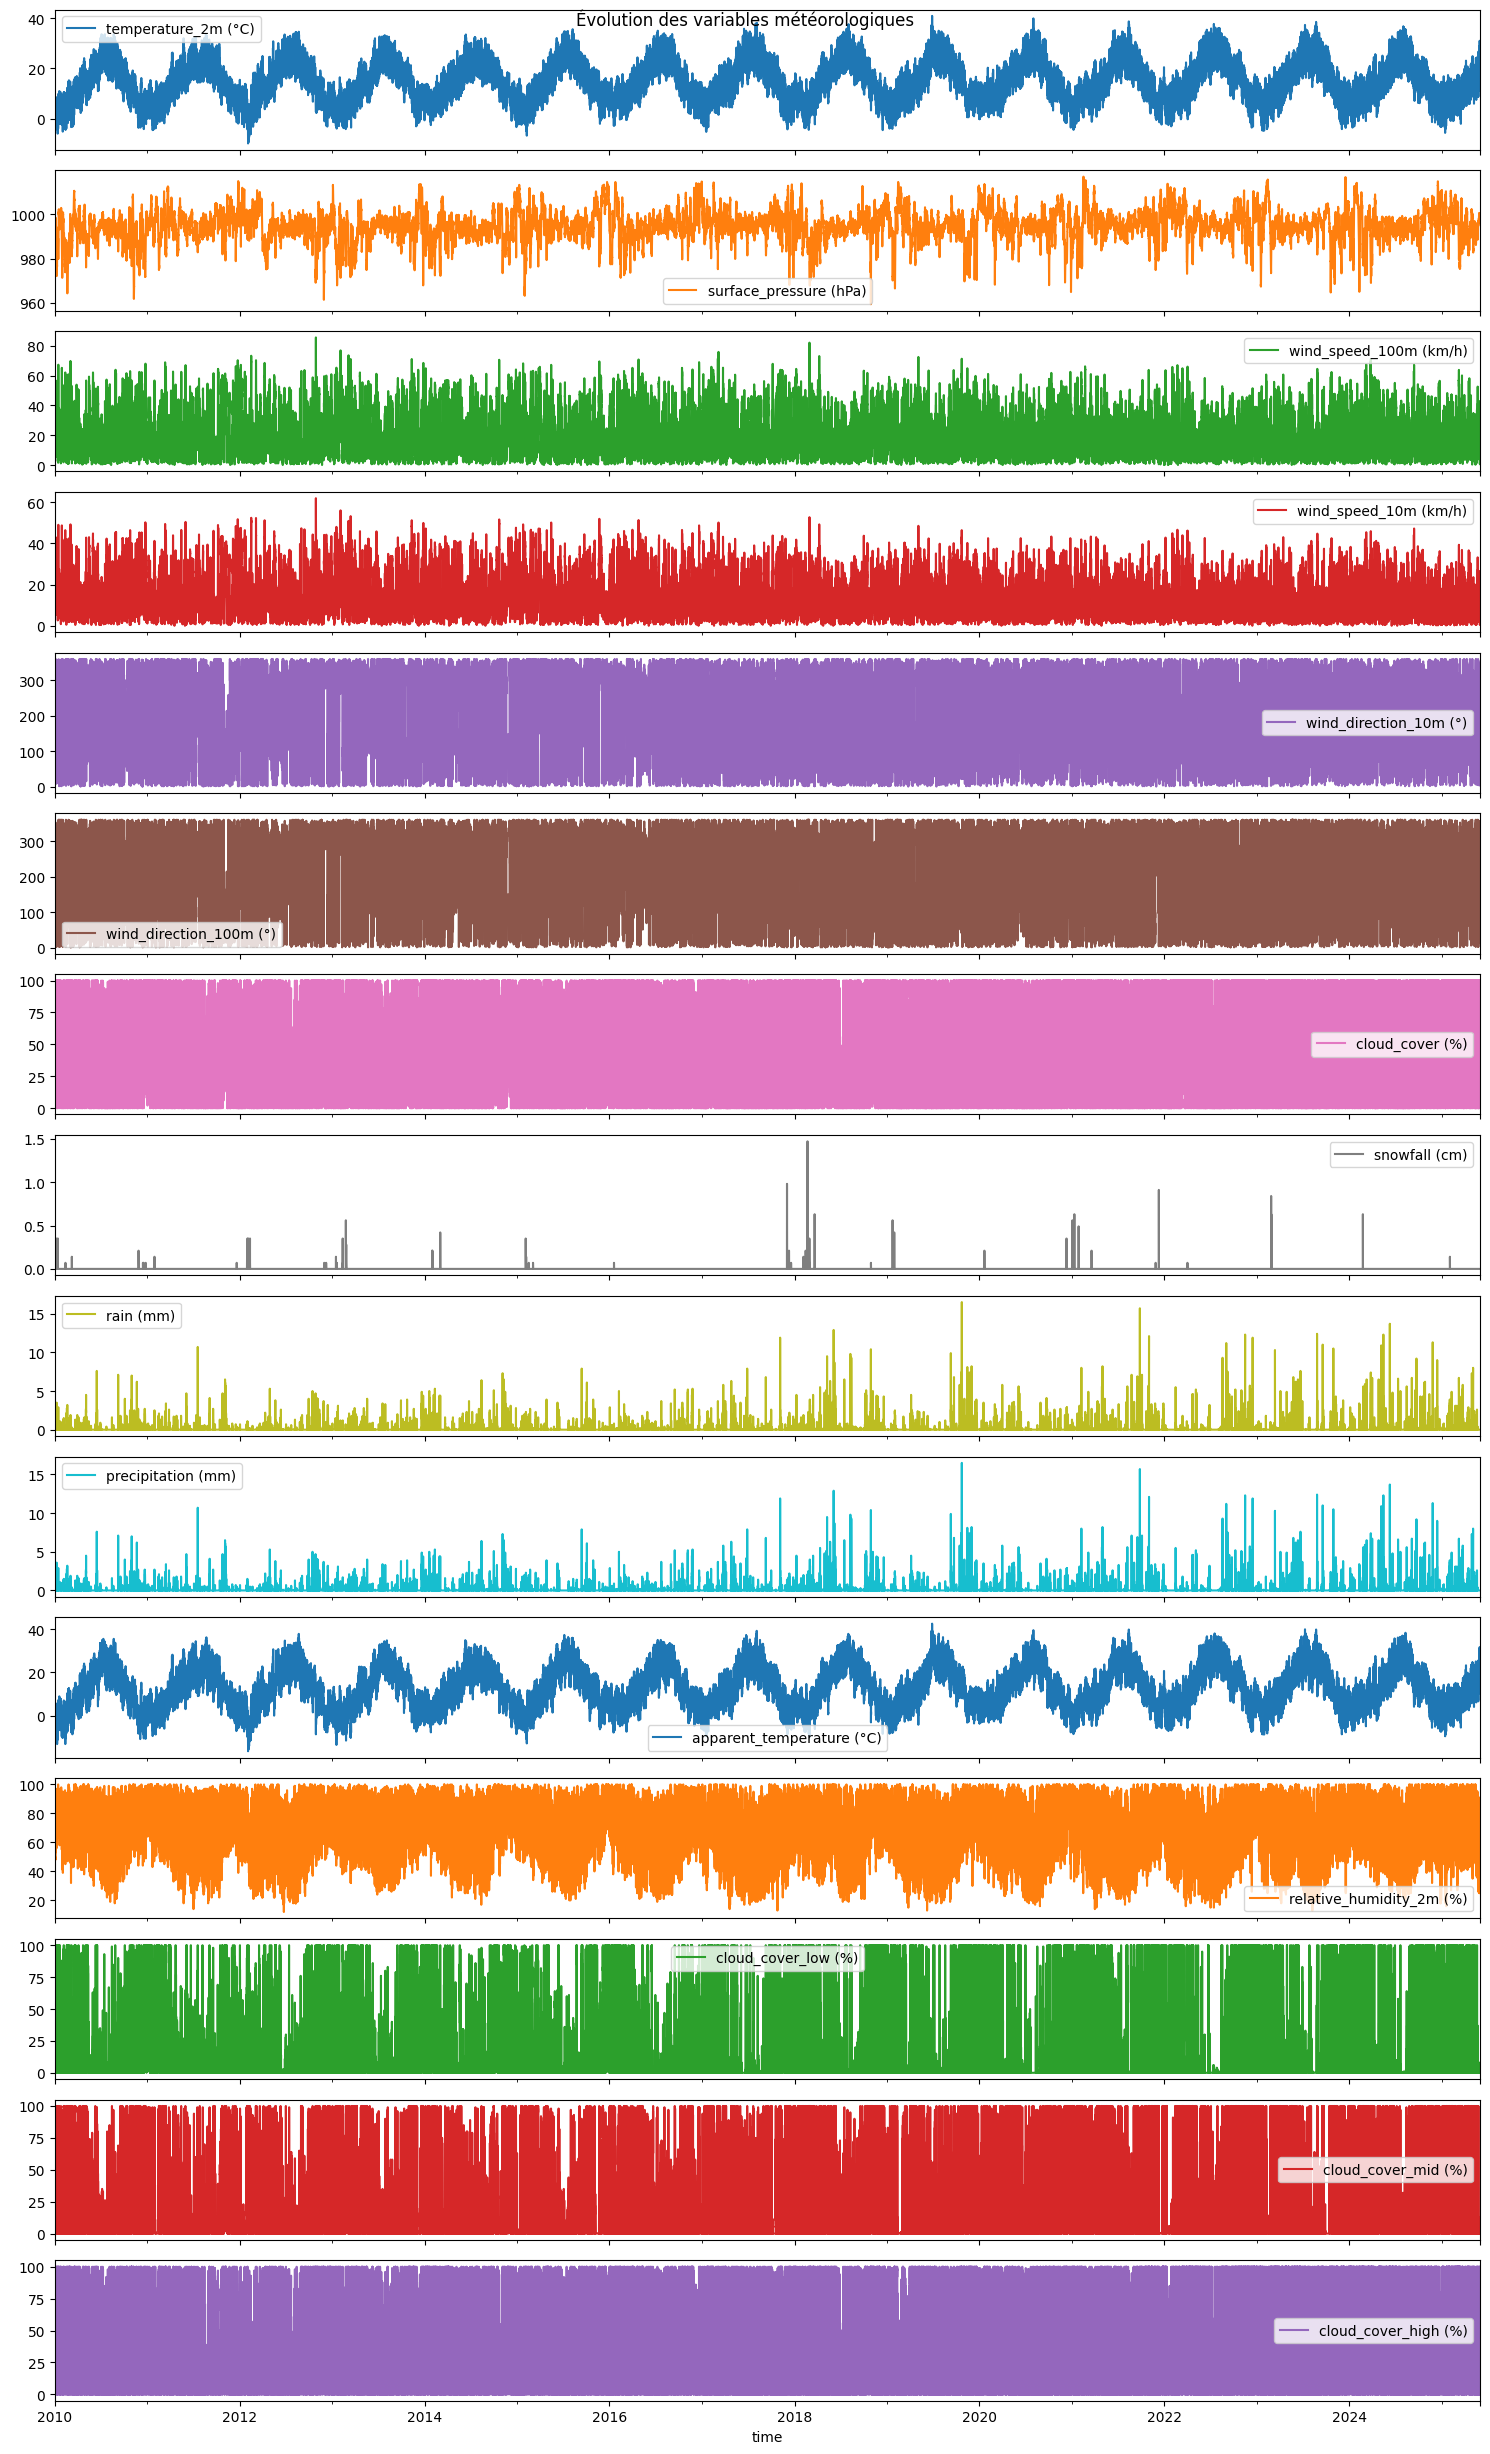

In [5]:

df.plot(subplots=True, figsize=(15, 25), title='Évolution des variables météorologiques')
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Évolution de la température à 2m'}, xlabel='time'>

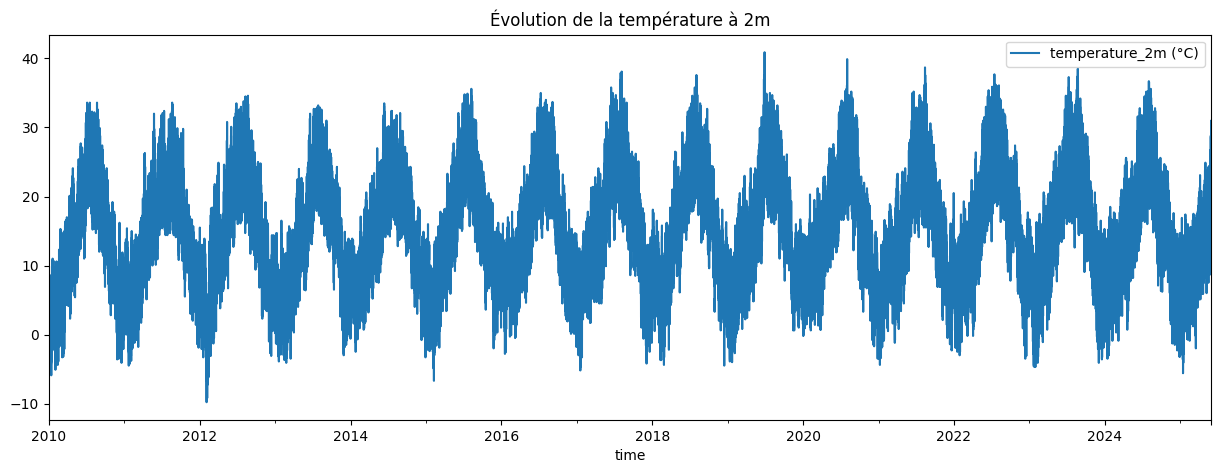

In [9]:

target = "temperature_2m (°C)"
df_target = df[[target]]
df_target.plot(figsize=(15,5), title="Évolution de la température à 2m")


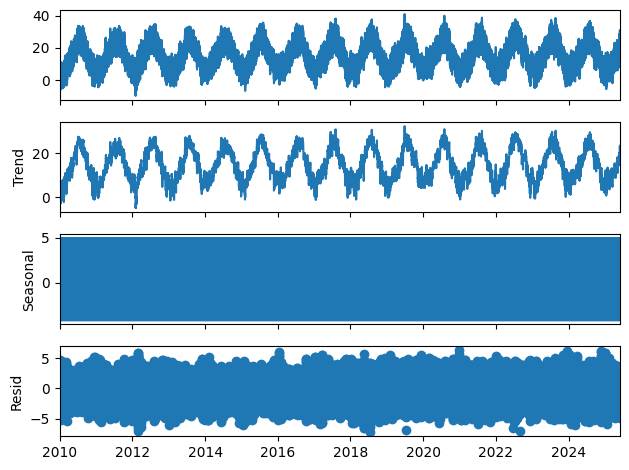

In [10]:

result = seasonal_decompose(df_target, model='additive')
result.plot()
plt.show()




## 10. Comprendre le Modèle SARIMA

Le modèle **SARIMA** est une extension du modèle ARIMA pour les données saisonnières.
Il a les paramètres suivants :
- **AR (p)** : dépendance des valeurs passées (auto-régression)
- **I (d)** : différenciation pour rendre la série stationnaire
- **MA (q)** : dépendance sur les erreurs passées
- **Saisonniers (P, D, Q, s)** :
  - P : ordre auto-régressif saisonnier
  - D : différenciation saisonnière
  - Q : moyenne mobile saisonnière
  - s : longueur du cycle saisonnier (par ex. 24 pour un cycle journalier horaire)

Nous allons utiliser un SARIMA(p=1,d=1,q=1)(P=1,D=1,Q=1,s=24) comme point de départ.



In [11]:

train = df_target.iloc[:-168]  # Entraînement sur tout sauf la dernière semaine
test = df_target.iloc[-168:]  # Test sur la dernière semaine


In [12]:

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,24))
results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                temperature_2m (°C)   No. Observations:               134952
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -127690.336
Date:                            Wed, 04 Jun 2025   AIC                         255390.671
Time:                                    00:32:38   BIC                         255439.734
Sample:                                01-01-2010   HQIC                        255405.363
                                     - 05-24-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2910      0.006     47.131      0.000       0.279       0.303
ma.L1          0.0330      0.006   

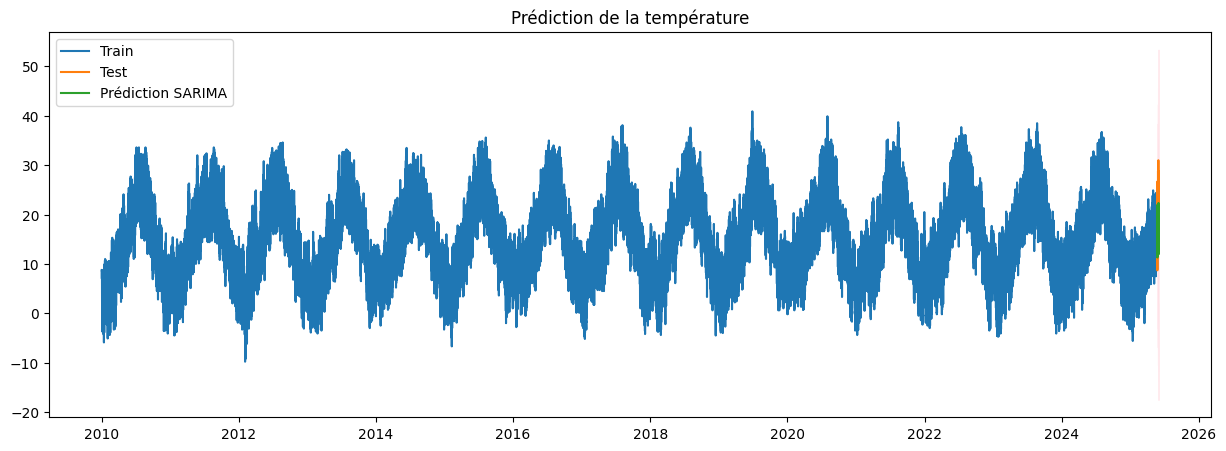

In [21]:

# pred = results.predict(start=test.index[0], end=test.index[-1], dynamic=False)
# #pred = results.get_forecast(steps=len(test))
# plt.figure(figsize=(15,5))
# plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Test')
# plt.plot(pred.index, pred, label='Prédiction SARIMA')
# plt.legend()
# plt.title('Prédiction de la température')
# plt.show()
forecast = results.get_forecast(steps=24*7)  # Prévision pour une semaine
pred = forecast.predicted_mean
plt.figure(figsize=(15,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Prédiction SARIMA')
plt.fill_between(pred.index, forecast.conf_int()['lower temperature_2m (°C)'], 
                 forecast.conf_int()['upper temperature_2m (°C)'], color='pink', alpha=0.3)
plt.legend()
plt.title('Prédiction de la température')
plt.show()

In [12]:

print("MAE (Erreur Absolue Moyenne):", mean_absolute_error(test, pred))
print("RMSE (Racine de l'Erreur Quadratique Moyenne):", np.sqrt(mean_squared_error(test, pred)))


MAE (Erreur Absolue Moyenne): 4.185174862417118
RMSE (Racine de l'Erreur Quadratique Moyenne): 4.65397594233298




## 15. Conclusion

Le modèle SARIMA permet de capturer à la fois les tendances globales et les comportements saisonniers de la température.
Il offre une base robuste pour la prévision météorologique. Pour améliorer les résultats, on peut ajuster les paramètres du modèle ou utiliser d'autres techniques comme les réseaux neuronaux récurrents (RNN).